In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))
from src.features import StylisticFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
# Loading sample dataset for first tests
df = pd.read_parquet("../data/hc3_full.parquet")

print(df.shape)
df.head()

(82415, 4)


,text,source,question,label
0,"Basically there are many categories of "" Best ...",reddit_eli5,"Why is every book I hear about a "" NY Times # ...",human
1,"If you 're hearing about it , it 's because it...",reddit_eli5,"Why is every book I hear about a "" NY Times # ...",human
2,"One reason is lots of catagories . However , h...",reddit_eli5,"Why is every book I hear about a "" NY Times # ...",human
3,salt is good for not dying in car crashes and ...,reddit_eli5,"If salt is so bad for cars , why do we use it ...",human
4,"In Minnesota and North Dakota , they tend to u...",reddit_eli5,"If salt is so bad for cars , why do we use it ...",human


In [34]:
# Keeping just the inputs & target
df = df[["text", "label"]].dropna(subset=["text", "label"])

# Deduplicate by lightly normalised text (case/whitespace)
_df = df.assign(
    _text_norm=lambda d: d["text"].str.lower().str.replace(r"\s+", " ", regex=True).str.strip()
)
before = len(_df)
df = _df.drop_duplicates(subset=["_text_norm"]).drop(columns=["_text_norm"]).reset_index(drop=True)
after = len(df)
print(f"Deduped: {before} → {after} rows (removed {before-after})")

df["label"].value_counts()

Deduped: 82415 → 79330 rows (removed 3085)


label
human    53086
ai       26244
Name: count, dtype: int64

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"],
    test_size=0.20,
    random_state=42,
    stratify=df["label"]
)

len(X_train), len(X_test)
# Sanity check: no exact overlap now
print("Overlap count:", len(set(X_train).intersection(set(X_test))))

Overlap count: 0


In [36]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words="english", 
    lowercase=True,
    strip_accents="unicode"
)

features = ColumnTransformer(
    transformers=[
        ("tfidf", tfidf, "text"),
        ("style", StylisticFeatures(), "text"),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

In [37]:
# Building pipeline with classifier
pipeline = Pipeline([
    ("features", features),
    ("clf", LogisticRegression(max_iter=100, solver="liblinear"))
])

In [38]:
# Training the pipeline on train data
pipeline.fit(X_train.to_frame(name="text"), y_train)

,steps,"[('features', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('tfidf', ...), ('style', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [39]:
y_pred = pipeline.predict(X_test.to_frame(name="text"))

In [40]:
print(classification_report(y_test, y_pred))

# Probabilities for ROC-AUC (treating "ai" as the positive class)
proba = pipeline.predict_proba(X_test.to_frame(name="text"))
classes = pipeline.named_steps["clf"].classes_
pos_idx = list(classes).index("ai")
roc = roc_auc_score((y_test == "ai").astype(int), proba[:, pos_idx])
print("ROC-AUC (ai positive):", round(roc,4))

              precision    recall  f1-score   support

          ai       0.95      0.94      0.95      5249
       human       0.97      0.98      0.97     10617

    accuracy                           0.96     15866
   macro avg       0.96      0.96      0.96     15866
weighted avg       0.96      0.96      0.96     15866

ROC-AUC (ai positive): 0.993


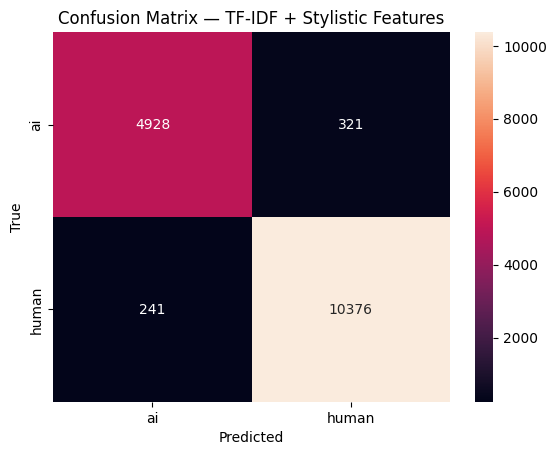

In [41]:
cm = confusion_matrix(y_test, y_pred, labels=classes)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix — TF-IDF + Stylistic Features")
plt.show()


In [42]:
# Check for exact duplicates between train and test
train_set = set(X_train)
test_set = set(X_test)

overlap = train_set.intersection(test_set)
print("Overlap count:", len(overlap))


Overlap count: 0


In [43]:
# How many questions appear in BOTH train and test?
q_train = set(df.loc[X_train.index, "question"]) if "question" in df.columns else set()
q_test  = set(df.loc[X_test.index,  "question"]) if "question" in df.columns else set()
q_overlap = q_train.intersection(q_test)
print("Questions shared across splits:", len(q_overlap))


Questions shared across splits: 0


In [44]:
# names for TF-IDF features
tfidf_feature_names = pipeline.named_steps['features'].transformers_[0][1].get_feature_names_out()

# Names for stylistic features
style_feature_names = ["avg_sentence_length", "type_token_ratio", "pronoun_rate"]

all_features = np.concatenate([tfidf_feature_names, style_feature_names])


In [45]:
# model coefficients
coefs = pipeline.named_steps['clf'].coef_[0]

coef_df = pd.DataFrame({
    "feature": all_features,
    "coefficient": coefs
})

# Sort by absolute importance
coef_df["abs_coeff"] = coef_df["coefficient"].abs()
coef_df = coef_df.sort_values("abs_coeff", ascending=False)

coef_df.head(20)

,feature,coefficient,abs_coeff
5001,type_token_ratio,12.777378,12.777378
2221,important,-10.482362,10.482362
4718,url_0,9.580035,9.580035
2082,help,-9.142735,9.142735
2247,including,-8.963220,8.963220
5002,pronoun_rate,8.436095,8.436095
416,basically,8.276633,8.276633
615,ca,8.241253,8.241253
2097,helps,-7.279490,7.279490
2227,important note,-6.710992,6.710992


C:\Users\Faith.Khan\AppData\Local\Temp\ipykernel_19780\1094535795.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


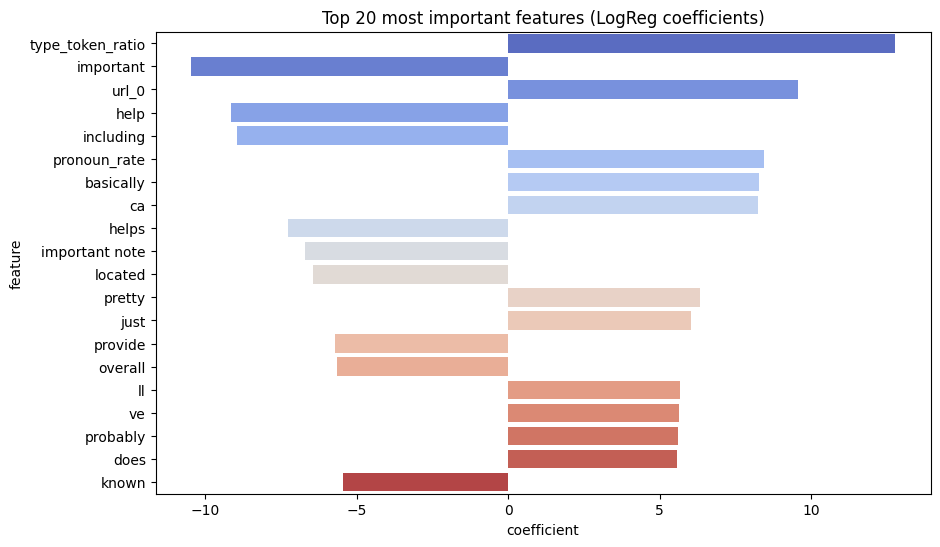

In [46]:
top_n = 20
plt.figure(figsize=(10,6))
sns.barplot(
    x="coefficient", 
    y="feature", 
    data=coef_df.head(top_n),
    palette="coolwarm"
)
plt.title(f"Top {top_n} most important features (LogReg coefficients)")
plt.show()
